# Linear evaluation protocol

Linear evaluation: построение простых моделей на готовых эмбеддингах из SSL-UNet-reconstruction на маленькой выборки в 50к эпох.

Эмбеддинги собраны на новом энкодере (x3).

## Загрузка эмбеддингов и меток

In [48]:

import numpy as np
import os
import pandas as pd

# Загрузка эмбеддингов
emb_path = r'C:\Users\Таисия\Desktop\МФТИ\Диплом_BCI\SSL_reconstruction_50k\ssl_embeddings_512d_mean_50k.npz'
emb_path_x3 = r'C:\Users\Таисия\Desktop\МФТИ\Диплом_BCI\SSL_reconstruction_50k\ssl_embeddings_x3_mean_50k.npz'
npz = np.load(emb_path_x3)
print("Ключи в npz:", npz.files)

Ключи в npz: ['X']


In [49]:
X = npz["X"]

In [50]:
# Загрузка меток

labels_path = r'C:\Users\Таисия\Desktop\МФТИ\Диплом_BCI\Выборки\SSL\y_ssl_small.npy'
y = np.load(labels_path)

print("y shape:", y.shape)
print("Уникальные метки и их распределение:", np.unique(y, return_counts=True))

# Проверяем соответствие размеров
assert X.shape[0] == y.shape[0], \
    f"Несовпадение размерностей: X={X.shape[0]}, y={y.shape[0]}"


y shape: (50000,)
Уникальные метки и их распределение: (array([0, 1]), array([44516,  5484]))


## Train / Val / Test split

- 70% train
- 15% val
- 15% test

In [51]:
from sklearn.model_selection import train_test_split

# train + temp (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.3,          # 30% оставим под val+test
    random_state=42,
    stratify=y
)

# temp делим пополам на val и test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,          # итого: 70% train, 15% val, 15% test
    random_state=42,
    stratify=y_temp
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train: (35000, 128) Val: (7500, 128) Test: (7500, 128)


## Обучение простых моделей без подбора гиперпараметров

### Общая функция для обучения и оценки модели

In [52]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

def train_and_eval(model, model_name, 
                   X_train, y_train, 
                   X_test, y_test):
    """
    Базовая linear evaluation без использования валид. выборки.
    Обучаемся на train, оцениваемся на test.
    """
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", model),
    ])

    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    
    # для ROC-AUC пробуем достать вероятности или decision_function
    if hasattr(pipe.named_steps['clf'], "predict_proba"):
        y_proba = pipe.predict_proba(X_test)[:, 1]
    elif hasattr(pipe.named_steps['clf'], "decision_function"):
        y_proba = pipe.decision_function(X_test)
    else:
        y_proba = None
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    if y_proba is not None:
        roc_auc = roc_auc_score(y_test, y_proba)
    else:
        roc_auc = None
    
    print(f"=== {model_name} ===")
    print("Accuracy:", acc)
    print("F1:", f1)
    if roc_auc is not None:
        print("ROC-AUC:", roc_auc)
    else:
        print("ROC-AUC: не посчитать (нет вероятностей/score)")
    print("\nClassification report:\n", classification_report(y_test, y_pred))
    
    return {
        "model": model_name,
        "accuracy": acc,
        "f1": f1,
        "roc_auc": roc_auc,
    }


## LogisticRegression, Random Forest и Gradient Boosting

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

results = []

# 1) Линейная модель — Logistic Regression
logreg = LogisticRegression(
    max_iter=500,
    class_weight='balanced',   # на случай дисбаланса классов
    n_jobs=-1
)
results.append(
    train_and_eval(
        logreg, "LogisticRegression",
        X_train, y_train,
        X_test, y_test
    )
)

# 2) Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    n_jobs=-1,
    class_weight='balanced'    # если сильный дисбаланс
)
results.append(
    train_and_eval(
        rf, "RandomForest",
        X_train, y_train,
        X_test, y_test
    )
)

# 3) Gradient Boosting (сквозь sklearn)
gb = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3
)
results.append(
    train_and_eval(
        gb, "GradientBoosting",
        X_train, y_train,
        X_test, y_test
    )
)

# Сводная табличка с метриками
df_results = pd.DataFrame(results)
df_results


=== LogisticRegression ===
Accuracy: 0.5074666666666666
F1: 0.2045650301464255
ROC-AUC: 0.5561184672188666

Classification report:
               precision    recall  f1-score   support

           0       0.91      0.50      0.64      6678
           1       0.12      0.58      0.20       822

    accuracy                           0.51      7500
   macro avg       0.51      0.54      0.42      7500
weighted avg       0.82      0.51      0.60      7500

=== RandomForest ===
Accuracy: 0.8904
F1: 0.0024271844660194173
ROC-AUC: 0.5256429945005898

Classification report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94      6678
           1       0.50      0.00      0.00       822

    accuracy                           0.89      7500
   macro avg       0.70      0.50      0.47      7500
weighted avg       0.85      0.89      0.84      7500

=== GradientBoosting ===
Accuracy: 0.8901333333333333
F1: 0.0
ROC-AUC: 0.5623270731726867

Classi

,model,accuracy,f1,roc_auc
0,LogisticRegression,0.507467,0.204565,0.556118
1,RandomForest,0.890400,0.002427,0.525643
2,GradientBoosting,0.890133,0.000000,0.562327


**Вывод:** Модели не работают или работают плохо, SSL плохо отработал.

# Проверки

In [9]:
np.unique(y, return_counts=True)

(array([0, 1]), array([44516,  5484]))

In [15]:
np.set_printoptions(precision=6, suppress=True)
print(np.mean(X), np.std(X))
print(np.std(X, axis=0)[:10])

2.3839e-41 0.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [16]:
for i in range(5):
    print(i, y[i], X[i][:5])

0 0 [0. 0. 0. 0. 0.]
1 0 [0. 0. 0. 0. 0.]
2 0 [0. 0. 0. 0. 0.]
3 0 [0. 0. 0. 0. 0.]
4 0 [0. 0. 0. 0. 0.]


In [17]:
(np.min(X), np.max(X))

(np.float32(0.0), np.float32(6.196e-41))

In [18]:
np.any(X != 0)

np.True_

Проверим нормализованные данные

In [19]:
X_ready_path = r'C:\Users\Таисия\Desktop\МФТИ\Диплом_BCI\Выборки\SSL\X_ssl_small_norm.npy'
X_ready = np.load(X_ready_path)

X shape: (50000, 14, 208) dtype: float32
y shape: (50000,) classes: [44516  5484]
N target: 5484 N non-target: 44516


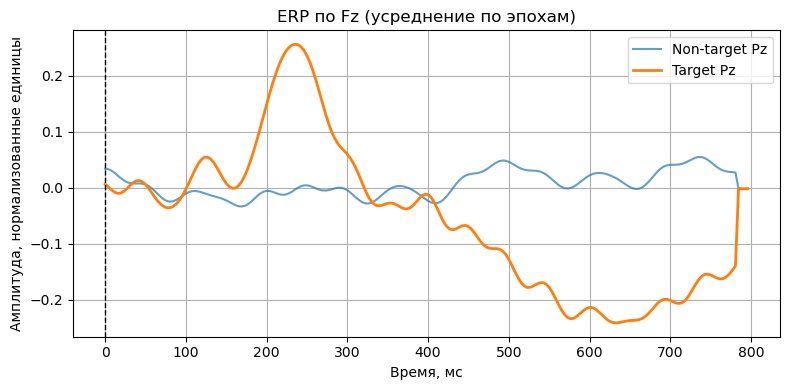

In [21]:
import numpy as np
import matplotlib.pyplot as plt


print("X shape:", X_ready.shape, "dtype:", X_ready.dtype)
print("y shape:", y.shape, "classes:", np.bincount(y))

CANONICAL_CHANNELS = [
    'Fz', 'Cz', 'Pz', 'Oz',
    'P3', 'P4', 'PO7', 'PO8',
    'F3', 'F4', 'C3', 'C4',
    'CP3', 'CP4'
]

# индекс канала Fz
pz_idx = CANONICAL_CHANNELS.index("Pz")

# делим на таргеты / нетаргеты
X_target = X_ready[y == 1]      # (N_t, 14, T)
X_nontarget = X_ready[y == 0]   # (N_nt, 14, T)

print("N target:", X_target.shape[0], "N non-target:", X_nontarget.shape[0])

# усредняем по эпохам
erp_fz_target = X_target[:, pz_idx, :].mean(axis=0)      # (T,)
erp_fz_nontarget = X_nontarget[:, pz_idx, :].mean(axis=0)  # (T,)

T = X_ready.shape[-1]
t = np.linspace(0, 0.8, T, endpoint=False)  # секунды, окно 0–800 мс

# Для наглядности переведём 
erp_fz_target_uV = erp_fz_target
erp_fz_nontarget_uV = erp_fz_nontarget

plt.figure(figsize=(8, 4))
plt.plot(t * 1000, erp_fz_nontarget_uV, label="Non-target Pz", alpha=0.7)
plt.plot(t * 1000, erp_fz_target_uV, label="Target Pz", linewidth=2)

plt.axvline(0, color="k", linestyle="--", linewidth=1)
plt.xlabel("Время, мс")
plt.ylabel("Амплитуда, нормализованные единицы")
plt.title("ERP по Fz (усреднение по эпохам)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
np.std(X_ready, axis=(0,2))

array([0.999996, 1.000001, 1.      , 0.999999, 0.999997, 0.999997,
       0.999998, 1.000002, 1.000001, 1.000001, 0.999998, 1.000002,
       0.999998, 0.999999], dtype=float32)

**Вывод:** проблема, скорее всего, в эмбеддингах 

In [23]:
print(np.min(X), np.max(X))
print(np.mean(X), np.std(X))
print(np.any(X != 0))

0.0 6.196e-41
2.3839e-41 0.0
True


In [24]:
print(npz.files)

['X']


Проверим энкодер

In [26]:
import torch

unet_path = r'C:\Users\Таисия\Desktop\МФТИ\Диплом_BCI\SSL_reconstruction_50k\unet_ssl_recon_50k.pth'

state = torch.load(unet_path, map_location="cpu")
print(type(state))

<class 'collections.OrderedDict'>


In [27]:
from models.unet_ssl import UNet1D_Light, UNet1DEncoder

In [28]:
unet = UNet1D_Light(
    n_channels=14,
    n_classes=14,   # у тебя reconstruction head → столько же каналов
    base_ch=32
)

In [29]:
state_path = r'C:\Users\Таисия\Desktop\МФТИ\Диплом_BCI\SSL_reconstruction_50k\unet_ssl_recon_50k.pth'
state = torch.load(state_path, map_location="cpu")
unet.load_state_dict(state)
unet.eval()

UNet1D_Light(
  (inc): DoubleConv1D(
    (block): Sequential(
      (0): Conv1d(14, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down1D(
    (block): Sequential(
      (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv1D(
        (block): Sequential(
          (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
          (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
          (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [30]:
encoder = UNet1DEncoder(unet)
encoder.eval()

UNet1DEncoder(
  (inc): DoubleConv1D(
    (block): Sequential(
      (0): Conv1d(14, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down1D(
    (block): Sequential(
      (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv1D(
        (block): Sequential(
          (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
          (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
          (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [31]:
x = torch.randn(1, 14, 208)

with torch.no_grad():
    feats = encoder(x)

print(feats.shape)      # должно быть torch.Size([1, 512, 13])
print(feats[0, :, :5])  # должны быть НЕ нули 

torch.Size([1, 512, 13])
tensor([[5.2274e-41, 5.2274e-41, 5.2274e-41, 5.2274e-41, 5.2274e-41],
        [5.0962e-41, 5.0962e-41, 5.0962e-41, 5.0962e-41, 5.0962e-41],
        [5.0192e-41, 5.0192e-41, 5.0192e-41, 5.0192e-41, 5.0192e-41],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]])


In [32]:
x = torch.randn(1, 14, 208)

with torch.no_grad():
    x1 = unet.inc(x)
    x2 = unet.down1(x1)
    x3 = unet.down2(x2)
    x4 = unet.down3(x3)
    x5 = unet.down4(x4)

for name, t in [("x1", x1), ("x2", x2), ("x3", x3), ("x4", x4), ("x5", x5)]:
    print(name, t.mean().item(), t.std().item())
    

x1 0.1717723160982132 0.2213977575302124
x2 0.013310613110661507 0.03516596928238869
x3 0.0014670713571831584 0.014039916917681694
x4 2.3931375173739226e-41 2.466845816597408e-41
x5 2.383888947509379e-41 2.5313055459563496e-41


**Вывод:** Сигнал умирает на уровне down3 → down4. Поэтому в качестве эмбеддингов надо брать x3, а не x5.

## Создаём новый энкодер и проверяем его вывод

In [36]:
import importlib
import models.unet_ssl
importlib.reload(models.unet_ssl)


<module 'models.unet_ssl' from 'c:\\Users\\Таисия\\Desktop\\МФТИ\\Диплом_BCI\\diploma-bciP300-ssl\\models\\unet_ssl.py'>

In [43]:
from models.unet_ssl import UNet1D_Light, UNet1DEncoderX3
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Создаём U-Net
unet = UNet1D_Light(n_channels=14, n_classes=14, base_ch=32)
state_path = r'C:\Users\Таисия\Desktop\МФТИ\Диплом_BCI\SSL_reconstruction_50k\unet_ssl_recon_50k.pth'
state = torch.load(state_path, map_location="cpu")
unet.load_state_dict(state)
unet.to(device)
unet.eval()

# 2. Создаём encoder на уровне x3
encoder = UNet1DEncoderX3(unet)
encoder.to(device)
encoder.eval()


UNet1DEncoderX3(
  (inc): DoubleConv1D(
    (block): Sequential(
      (0): Conv1d(14, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down1D(
    (block): Sequential(
      (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv1D(
        (block): Sequential(
          (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
          (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
          (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_run

Пересчитываем эмбеддинги

In [44]:
from torch.utils.data import Dataset, DataLoader
import numpy as np

class SSLDataset(Dataset):
    def __init__(self, X):
        self.X = X  # массив (N, 14, 208), float32

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32)

# Загружаем готовые нормализованные эпохи
X_ready_path = r'C:\Users\Таисия\Desktop\МФТИ\Диплом_BCI\Выборки\SSL\X_ssl_small_norm.npy'
X_ssl = np.load(X_ready_path) 

dataset = SSLDataset(X_ssl)
loader = DataLoader(dataset, batch_size=128, shuffle=False)


In [45]:
all_embs = []

with torch.no_grad():
    for batch in loader:
        batch = batch.to("cpu")             # (B, 14, 208)

        feats = encoder(batch)               # (B, ch3, L3)
        emb = feats.mean(dim=-1)             # усреднение по времени → (B, ch3)

        all_embs.append(emb.cpu().numpy())


In [46]:
# Объединяем в один массив
X_emb = np.concatenate(all_embs, axis=0)   # (N, ch3)

# Проверяем
print("New embeddings shape:", X_emb.shape)
print("min/max:", X_emb.min(), X_emb.max())
print("std:", X_emb.std())


New embeddings shape: (50000, 128)
min/max: 0.0 0.45391306
std: 0.0034774067


In [47]:
# Сохраняем эмбеддинги
save_path = r"C:\Users\Таисия\Desktop\МФТИ\Диплом_BCI\SSL_reconstruction_50k/ssl_embeddings_x3_mean_50k.npz"
np.savez(save_path, X=X_emb)
